In [3]:
pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.4 MB/s eta 0:00:0000:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [6]:
diabetes=pd.read_csv('diabetes.csv')
diabetes.head()
diabetes.Outcome.value_counts(dropna=False)

0    500
1    268
Name: Outcome, dtype: int64

# Assumptions of Logistic Reg

## No collinearity

In [7]:
# X/y split
X = diabetes.drop('Outcome',axis = 1)
y = diabetes['Outcome']

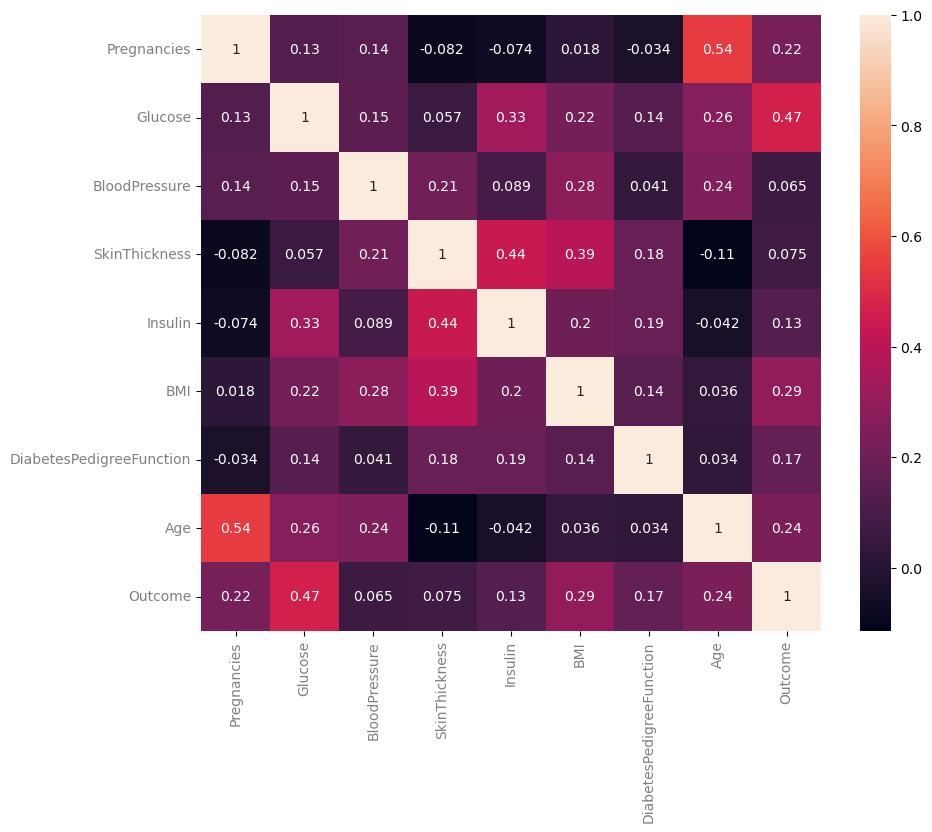

In [8]:
correlations_matrix = diabetes.corr()
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.heatmap(correlations_matrix, annot=True)
for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("grey")
    tick_label.set_fontsize("10")
for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("grey")
    tick_label.set_fontsize("10")
plt.show()

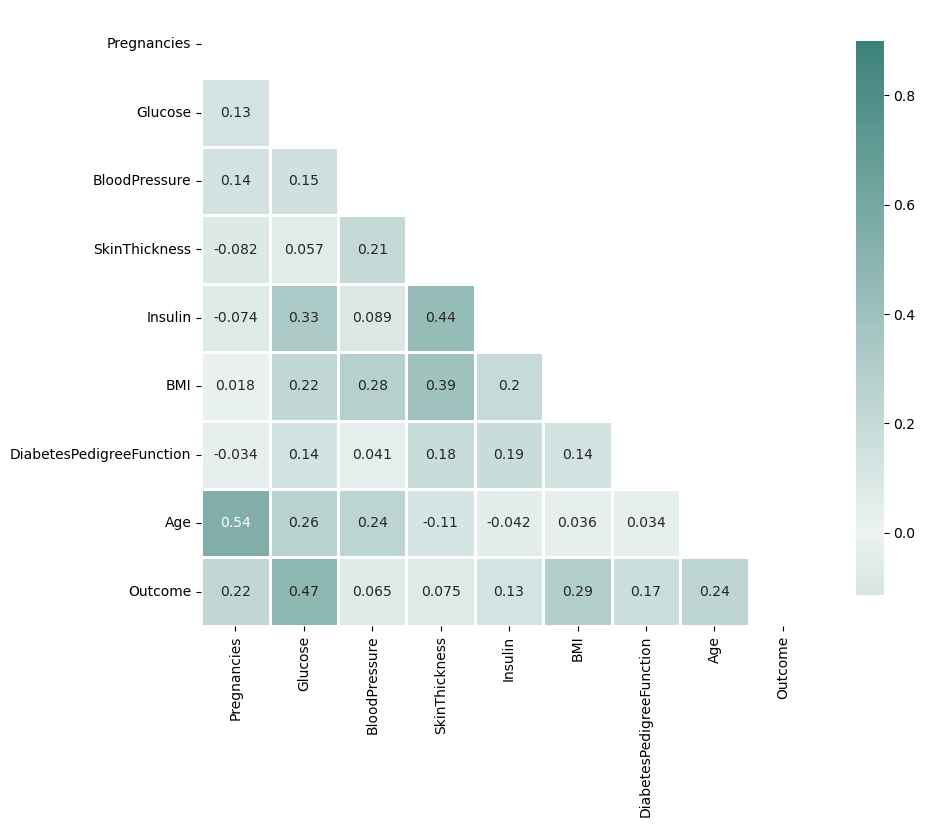

In [13]:
mask = np.zeros_like(correlations_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well?
# mask[np.diag_indices_from(mask)] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(180, 180, as_cmap=True)
# https://www.learnui.design/blog/the-hsb-color-system-practicioners-primer.html

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(correlations_matrix, mask=mask, cmap=cmap, vmax=.9, center=0,
        square=True, linewidths=.9, cbar_kws={"shrink": .9}, annot=True)
# save to file
fig = sns_plot.get_figure()
fig.savefig("features_heatmap.png")

## Standardization of independent variables

In [14]:
# here we start scaling, so need to do train-test-split before
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default fraction is test_size = 0.25 

In [15]:
# all features are numeric, so no need to split into _num and _cat
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X.columns)

# we can immediately transform the X_test as well
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X.columns)
X_train_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.507552,-1.015215,-0.404519,-1.319215,-0.718238,-1.220701,-0.983259,-0.048640
1,-0.829864,-0.099647,-0.615096,0.928730,0.083747,0.137191,-0.624936,-0.882466
2,-1.122041,-0.952072,0.543076,-1.319215,-0.718238,0.024033,0.398842,-0.548935
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038


In [16]:
# needed because the transformation also reset the index for X_train_scaled
# so we need this for y_test as well...
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)

# Imbalance and metrics

<AxesSubplot:>

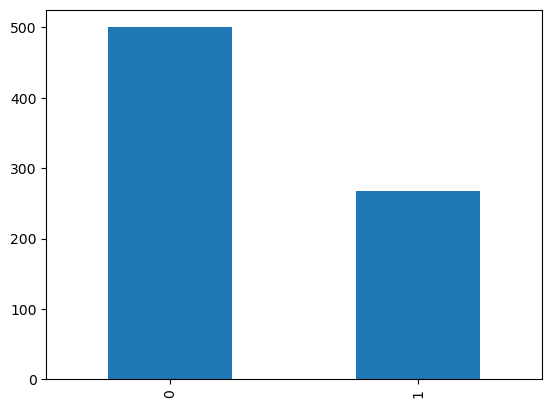

In [17]:
# while there are more imbalanced datasets, we have a significant imbalance
# and the cost of failing to detect the minority class is quite high (lack of diagnosis of diabetes)
count_classes = diabetes['Outcome'].value_counts()
count_classes.plot(kind = 'bar')

# A relatively bad model

In [18]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_scaled, y_train)
LR.score(X_test_scaled, y_test)

0.8020833333333334

In [ ]:
# What does this number mean??
# Discuss precision and recall

In [19]:
#while accuracy is not absolutely terrible, a closer look reveals some serious problems
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.75
recall:  0.5806451612903226
f1:  0.6545454545454547


In [20]:
#we fail to identify 40%+ of diabetes cases!
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)   # target then prediction!

array([[118,  12],
       [ 26,  36]])

In [21]:
confusion_matrix(y_test, pred)[1][0]

26

In [23]:
def evaluate_model(note, model, X_test, y_test, results):
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    false_negatives = confusion_matrix(y_test, pred)[1][0]
    new_result = pd.Series([note, score, precision, recall, f1, false_negatives], index=results.columns)
    return results.append(new_result, ignore_index=True)

results = pd.DataFrame(columns=['note','accuracy','precision','recall','f1_score', 'false_negatives'])

In [24]:
results

,note,accuracy,precision,recall,f1_score,false_negatives


In [25]:
results = evaluate_model('Before sampling', LR, X_test_scaled, y_test, results)
results

/var/folders/xp/jp6pr1sn3p50vy46h4q0ntqr0000gn/T/ipykernel_12249/3280535345.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results.append(new_result, ignore_index=True)


,note,accuracy,precision,recall,f1_score,false_negatives
0,Before sampling,0.802083,0.75,0.580645,0.654545,26


## Oversampling / Undersampling
#### note, I might say Upsampling / Downsampling - referring to same thing

In [ ]:
from sklearn.utils import resample

In [ ]:
# oversampling / undersampling is only to be done on the TRAINING set
# our test set still must reflect reality!
train = pd.concat([X_train_scaled, y_train],axis=1)
train.head()

## Oversampling

In [ ]:
# separate majority/minority classes
no_diabetes = train[train['Outcome']==0]
yes_diabetes = train[train['Outcome']==1]

In [ ]:
display(no_diabetes.shape)
display(yes_diabetes.shape)

In [ ]:
# oversample minority
yes_diabetes_oversampled = resample(yes_diabetes, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_diabetes),#<- make both sets the same size
                                    random_state=0)

In [ ]:
yes_diabetes.groupby(yes_diabetes.columns.tolist(),as_index=False).size()

In [ ]:
yes_diabetes_oversampled.groupby(yes_diabetes_oversampled.columns.tolist(),as_index=False).size()

In [ ]:
# both sets are now of a reasonable size
display(no_diabetes.shape)
display(yes_diabetes_oversampled.shape)

In [ ]:
train_oversampled = pd.concat([no_diabetes,yes_diabetes_oversampled],axis=0)
train_oversampled.tail()

In [ ]:
y_train_over = train_oversampled['Outcome'].copy()
X_train_over = train_oversampled.drop('Outcome',axis = 1).copy()

In [ ]:
# Our Logistic Regression, while still not amazing, has improved substantially!
# especially at detecting instances of diabetes
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_over, y_train_over)
pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

In [ ]:
confusion_matrix(y_test,pred)

In [ ]:
results = evaluate_model('Oversampling', LR, X_test_scaled, y_test, results)
results

## Undersampling

In [ ]:
# we already split our training data on the target variable...

# undersample majority
no_diabetes_undersampled = resample(no_diabetes, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = len(yes_diabetes),
                                    random_state=0)

In [ ]:
# both sets are the same size
# small, but balanced, and no repeated data
display(yes_diabetes.shape)
display(no_diabetes_undersampled.shape)

In [ ]:
train_undersampled = pd.concat([yes_diabetes,no_diabetes_undersampled])
train_undersampled.head()

In [ ]:
y_train_under = train_undersampled['Outcome'].copy()
X_train_under = train_undersampled.drop('Outcome',axis = 1).copy()

In [ ]:
# Still a slight improvement!
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_under, y_train_under)
pred = LR.predict(X_test_scaled)

results = evaluate_model('Undersampling', LR, X_test_scaled, y_test, results)
results

In [ ]:
confusion_matrix(y_test,pred)

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# a bit of magic, you can find documentation here: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
# by deafult, takes a 5-neighbour KNN to build a new point, experimenting led us to choose 3 here
sm = SMOTE(random_state=100,k_neighbors=9)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled,y_train)

In [ ]:
X_train_SMOTE.shape

In [ ]:
# yet another small improvement, but bear in mind that we saved 12 hypothetical people with
# these "small improvements"
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR.predict(X_test_scaled)

results = evaluate_model('SMOTE', LR, X_test_scaled, y_test, results)
results

In [ ]:
confusion_matrix(y_test,pred)